# 1. Libraries and Data Import

In [2]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *

In [7]:
'''
Code to download images from Bing
Valid Azure search key to be provided in place of xxx

import os
key = os.environ.get('AZURE_SEARCH_KEY', 'xxx')

path = Path('images')
if not path.exists():
    path.mkdir()

# People with mask
dest = (path/'mask')
dest.mkdir(exist_ok=True)
results = search_images_bing(key, 'People wearing mask')
download_images(dest, urls=results.attrgot('contentUrl'))

# People without mask
dest = (path/'no mask')
dest.mkdir(exist_ok=True)
results = search_images_bing(key, 'People')
download_images(dest, urls=results.attrgot('contentUrl'))
'''

"\nCode to download images from Bing\nValid Azure search key to be provided in place of xxx\n\nimport os\nkey = os.environ.get('AZURE_SEARCH_KEY', 'xxx')\n\npath = Path('images')\nif not path.exists():\n    path.mkdir()\n\n# People with mask\ndest = (path/'mask')\ndest.mkdir(exist_ok=True)\nresults = search_images_bing(key, 'People wearing mask')\ndownload_images(dest, urls=results.attrgot('contentUrl'))\n\n# People without mask\ndest = (path/'no mask')\ndest.mkdir(exist_ok=True)\nresults = search_images_bing(key, 'People')\ndownload_images(dest, urls=results.attrgot('contentUrl'))\n"

In [3]:
pwd

'/kaggle/working'

In [4]:
# Data loaded from kaggle dataset: https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

path = '../input/face-mask-12k-images-dataset/Face Mask Dataset'

In [5]:
# Getting all filenames
fns = get_image_files(path)
fns

(#11792) [Path('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/1017.png'),Path('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/4803.png'),Path('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/5106.png'),Path('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/3765.png'),Path('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/780.png'),Path('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/3952.png'),Path('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/227.png'),Path('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/2731.png'),Path('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/579.png'),Path('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/353.png')...]

In [6]:
# Checking if there are invalid filenames
failed = verify_images(fns)
failed

(#0) []

In [8]:
# Creating datablock
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_items=get_image_files, 
                   splitter=GrandparentSplitter(train_name='Train',valid_name='Validation'),
                   get_y=parent_label,
                   item_tfms=Resize(128))

In [9]:
# Creating dataloaders
dls = dblock.dataloaders(path)

In [12]:
dls.vocab

['WithMask', 'WithoutMask']

In [11]:
# Checking if there has been any issues with datablock creation
dblock.summary(path)

Setting-up type transforms pipelines
Found 11792 items
2 datasets of sizes 10000,800
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask/5511.png
    applying PILBase.create gives
      PILImage mode=RGB size=112x112
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask/5511.png
    applying parent_label gives
      WithoutMask
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=112x112, TensorCategory(1))


Found 11792 items
2 datasets of sizes 10000,800
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {

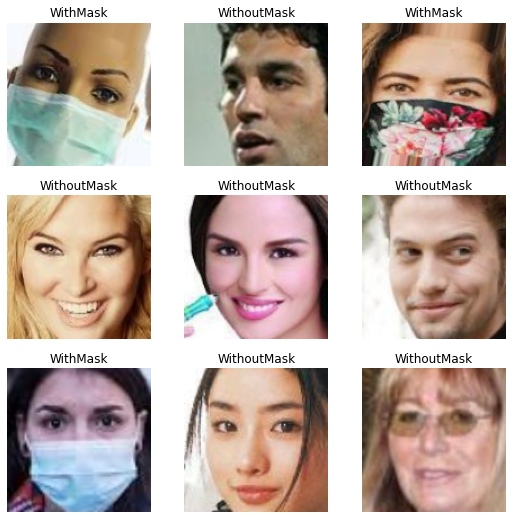

In [19]:
# Showing training images
dls.train.show_batch()

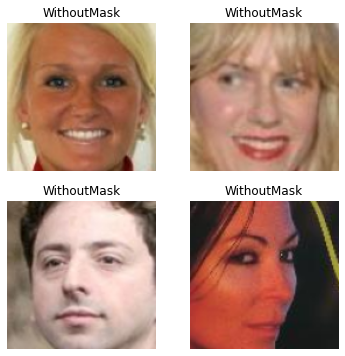

In [20]:
# Showing validation images
dls.valid.show_batch(max_n=4)

# 2. Data Augmentation

In [21]:
# Creating a new datablock object with augmentations applied
newblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                    batch_tfms=aug_transforms())
dls = newblock.dataloaders(path)

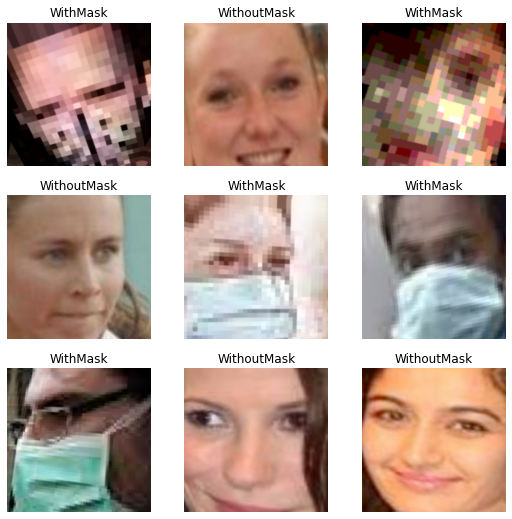

In [22]:
dls.show_batch()

# 3. Model Training

In [28]:
# Finetuning resnet18 without any hyperparameter changes
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.101484,0.331143,0.123750,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.027169,0.231460,0.086250,00:40
1,0.015106,0.035829,0.011250,00:39
2,0.010960,0.192435,0.058750,00:40
3,0.003839,0.182829,0.056250,00:40


In [34]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.0004786300996784121)

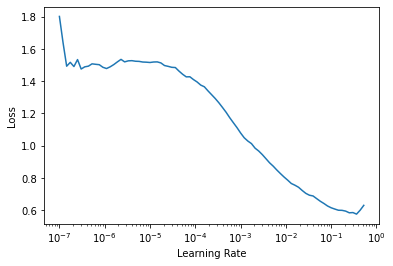

In [35]:
# Base learning rate finder
learn.lr_find()

In [36]:
# Fitting one epoch with only last layer unfrozen
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.072172,0.114516,0.041250,00:38


SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=2.75422871709452e-06)

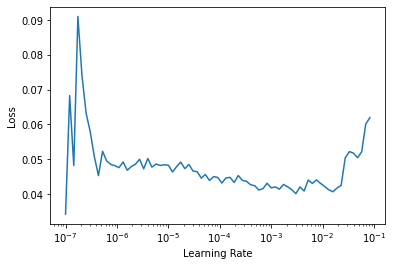

In [37]:
# Finding lr again for full network training
learn.lr_find()

In [38]:
# Unfreezing the whole network
learn.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=6.309573450380412e-07)

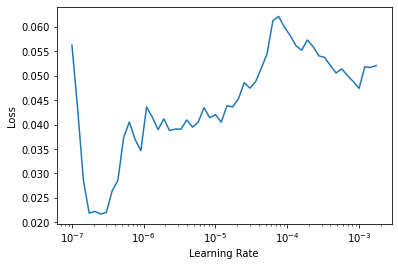

In [39]:
learn.lr_find()

In [40]:
# Training the whole network with discriminative lr
learn.fit_one_cycle(3, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.031406,0.067806,0.025000,00:40
1,0.019663,0.058216,0.022500,00:40
2,0.017757,0.061503,0.020000,00:40


In [55]:
# Directly using finetune with optimized base_lr and a weight decay parameter (which has been found after multiple trials not shown here)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3, base_lr=1e-3, wd=0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.130878,0.455112,0.167500,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.026785,0.102177,0.037500,00:40
1,0.017032,0.093651,0.022500,00:40
2,0.006620,0.069623,0.015000,00:40


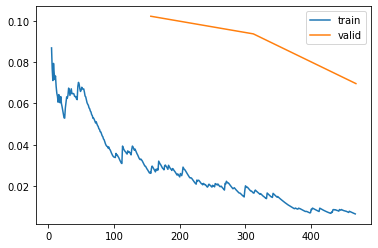

In [56]:
# Plot train vs valid loss
learn.recorder.plot_loss()

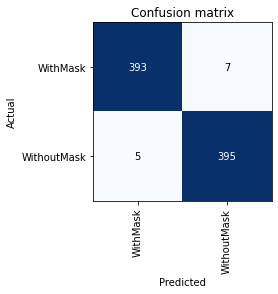

In [57]:
# Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

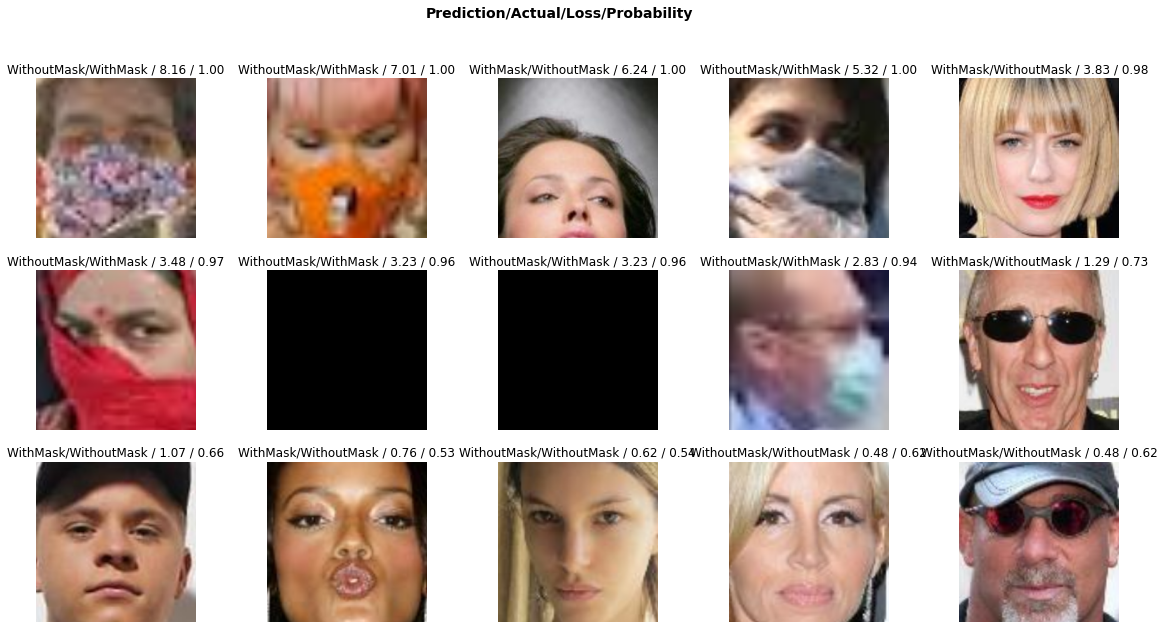

In [67]:
# Plotting top losses
interp.plot_top_losses(15, nrows=3, figsize=(20,10))

## Model Testing

You are not wearing a mask; I can say that with probability: 1.00


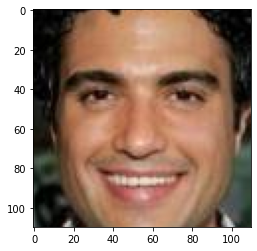

In [104]:
img = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask/1388.png'
plt.imshow(plt.imread(img))
pred, t, prob = learn.predict(img)
if pred == 'WithMask': 
    pred_to_print = 'Great! You are wearing a face mask'
else: pred_to_print = 'You are not wearing a mask'
    
print(f'{pred_to_print}; I can say that with probability: {prob[t]:.2f}')

In [78]:
learn.dls.vocab

['WithMask', 'WithoutMask']

## Exporting for external use

In [105]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')